## Libraries

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import librosa
import os
import seaborn as sns
from sklearn.model_selection import train_test_split

import shutil
from google.colab import drive
from google.colab import files

import io
from keras.layers import Dense, Input, Flatten, LeakyReLU, Reshape, Dropout
from tensorflow.keras.layers import Input, Dense, Reshape, BatchNormalization, UpSampling2D, Conv2D, BatchNormalization, Reshape, Conv2DTranspose, ReLU
from keras.models import Model, Sequential
import tensorflow as tf
import re
import unicodedata
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, accuracy_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

import torch.optim as optim
from transformers import BertModel
import torch
from tensorflow.keras.datasets import mnist

## Preprocess MNIST

In [6]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


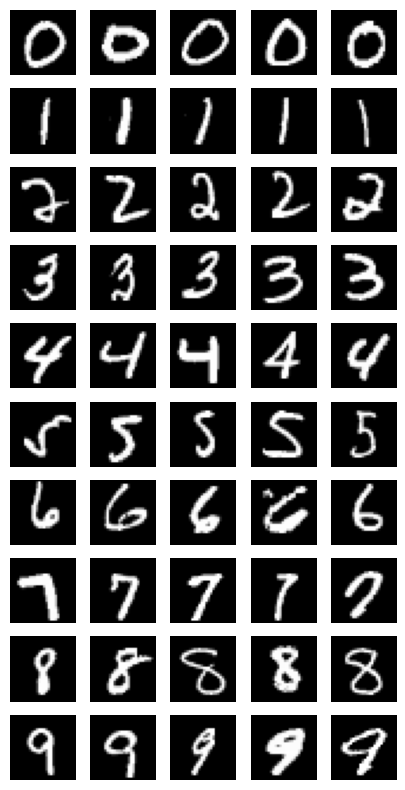

In [ ]:
num_classes = 10

def plot_images_per_class(images, labels, num_samples=5):
    fig, axes = plt.subplots(num_classes, num_samples, figsize=(num_samples, num_classes))

    for class_label in range(num_classes):
        class_indices = np.where(labels == class_label)[0]
        random_indices = np.random.choice(class_indices, num_samples, replace=False)

        for i, index in enumerate(random_indices):
            axes[class_label, i].imshow(images[index], cmap='gray')
            axes[class_label, i].axis('off')

    plt.show()

plot_images_per_class(train_images, train_labels)


In [28]:
X = np.vstack((train_images,test_images))
X = X.astype('float32')
X = X / 255.0
X = X.reshape((X.shape[0], 28, 28, 1))
X = X.reshape((X.shape[0], 1, 28, 28))

In [29]:
X.shape

(70000, 1, 28, 28)

## 2-1. GAN on MNIST

In [20]:
def make_generator(input_size, output_shape):
    model = Sequential()
    model.add(Dense(128, input_dim=input_size))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(output_shape), activation='sigmoid'))
    model.add(Reshape(output_shape))
    return model

def make_discriminator(input_shape):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

def make_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model




In [25]:
input_size = 100
output_shape = (28, 28, 1)
generator = make_generator(input_size, output_shape)
discriminator = make_discriminator(output_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
discriminator.trainable = False
gan = make_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
generator.summary()
discriminator.summary()
gan.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 128)               12928     
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 128)               0         
                                                                 
 batch_normalization_17 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_26 (Dense)            (None, 256)               33024     
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 256)               0         
                                                                 
 batch_normalization_18 (Ba  (None, 256)               1024      
 tchNormalization)                                    

In [27]:
import matplotlib.pyplot as plt
import numpy as np

def train_gan(generator, discriminator, gan, X_train, epochs, batch_size):
    half_batch = batch_size // 2

    for epoch in range(epochs):
        # Train discriminator
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        real_imgs = X_train[idx]

        noise = np.random.normal(0, 1, (half_batch, 100))
        fake_imgs = generator.predict(noise)

        real_labels = np.ones((half_batch, 1))
        fake_labels = np.zeros((half_batch, 1))

        d_loss_real = discriminator.train_on_batch(real_imgs, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_imgs, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_labels = np.ones((batch_size, 1))

        g_loss = gan.train_on_batch(noise, valid_labels)

        # Print progress
        print(f"{epoch}/{epochs} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")

        # Save generated samples at specified intervals
        if epoch % 100 == 0:
            save_generated_samples(generator, epoch)

def save_generated_samples(generator, epoch, examples=10, dim=(1, 10), figsize=(10, 1)):
    noise = np.random.normal(0, 1, (examples, 100))
    generated_imgs = generator.predict(noise)
    generated_imgs = 0.5 * generated_imgs + 0.5  # Rescale pixel values

    fig, axs = plt.subplots(dim[0], dim[1], figsize=figsize)
    for i in range(dim[0] * dim[1]):
        axs[i].imshow(generated_imgs[i, :, :, 0], cmap='gray')
        axs[i].axis('off')

    plt.savefig(f"gan_generated_image_epoch_{epoch}.png")
    plt.close()

# Set hyperparameters
epochs = 6000
batch_size = 64

# Train the GAN
train_gan(generator, discriminator, gan, X, epochs, batch_size)


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 22ms/step
3512/6000 [D loss: 0.17099271714687347 | D accuracy: 92.1875] [G loss: 3.252811908721924]
1/1 [==============================] - 0s 18ms/step
3513/6000 [D loss: 0.28405626863241196 | D accuracy: 87.5] [G loss: 2.319251775741577]
1/1 [==============================] - 0s 17ms/step
3514/6000 [D loss: 0.31472963839769363 | D accuracy: 87.5] [G loss: 3.056764602661133]
1/1 [==============================] - 0s 22ms/step
3515/6000 [D loss: 0.3828475922346115 | D accuracy: 87.5] [G loss: 2.3206706047058105]
1/1 [==============================] - 0s 23ms/step
3516/6000 [D loss: 0.28114984929561615 | D accuracy: 87.5] [G loss: 2.3427693843841553]
1/1 [==============================] - 0s 23ms/step
3517/6000 [D loss: 0.3252706378698349 | D accuracy: 90.625] [G loss: 3.0300498008728027]
1/1 [==============================] - 0s 19ms/step
3518/6000 [D loss: 0.28117281198501587 | D accuracy: 90.6